# Purpose: 
Generate a fire perimeter in GeoJSON based on the input pre and post flight images

In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/uavsar-main/python").resolve()
sys.path.append(str(utils_path))

import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.plot import show
# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from process_utils import (preprocess_data, 
                           superpixel_segmentation,
                           get_superpixel_model_labels,
                           convert_labels_to_gdf,
                           filter_by_area,
                           merge_geojson,
                           tv_denoise)
from nd_utils import (get_superpixel_means_as_features,
                      get_superpixel_stds_as_features,get_superpixel_medians_as_features,
                      get_array_from_features)
# # from process_utils import (preprocess_data, 
#                            get_model_labels)
from rio_utils import (reproject_arr_to_match_profile)
from shapely.geometry import Polygon
from shapely.geometry import Point
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from matplotlib.colors import ListedColormap


In [2]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the preprocessed images
- `superpixel_labels_list` (list): a list containing the paths to the superpixel labels

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
        transform = ds.transform
    return band, profile, transform

In [4]:
# Path to the folder with the preprocessed images
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km")
tifs = sorted(list(data_dir.glob('./*_preprocessed*.tif')))
tifs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km/hv_0_45km_40km_rectangle_preprocessed_interpolated.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km/hv_1_45km_40km_rectangle_preprocessed_interpolated.tif')]

---
Open the preprocessed images and load the superpixel segmentation corresponded to the pre- and post- fire.

- Let `hv_0` correspond to the pre-fire image and `hv_1` correspond to the post-fire image. 
- Let `profile` and `transform` correspond to the pre-fire image.
- Let `superpixel_labels` be the output of the segmentation

In [5]:
# open the tifs
bands_tv, profiles, transforms = zip(*map(open_one, tifs))
hv_0 = bands_tv[0]
hv_1 = bands_tv[1]
profile = profiles[0]
transform = transforms[0]

In [6]:
hv_0 = denoise(hv_0,5)
hv_1 = denoise(hv_1,5)

---
This is the preprocessed raster image we will work with to extract the fire perimeter

In [7]:
# compute log ratio and filter out the vegetation gain by setting to no change.
log_ratio = 10*np.log10(hv_0/hv_1)

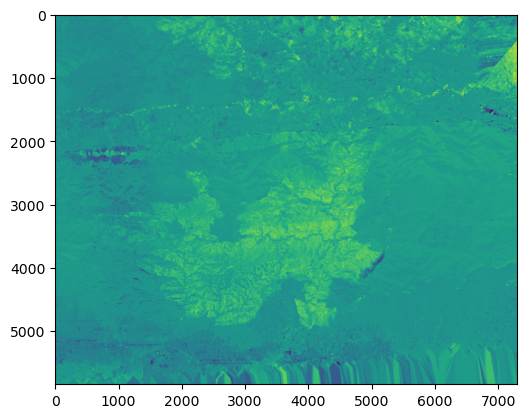

In [8]:
plt.imshow(log_ratio)

In [9]:
# Load if we have performed segmentation previously

superpixel_labels = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km/superpixel_labels_test_230727_231017_min1000.npy")

In [10]:
print("superpizel_labels: ")
print(superpixel_labels)

superpizel_labels: 
[[   0    0    0 ...  118  118  118]
 [   0    0    0 ...  118  118  118]
 [   0    0    0 ...  118  118  118]
 ...
 [8721 8721 8721 ... 8653 8653 8653]
 [8721 8721 8721 ... 8653 8653 8653]
 [8721 8721 8721 ... 8653 8653 8653]]


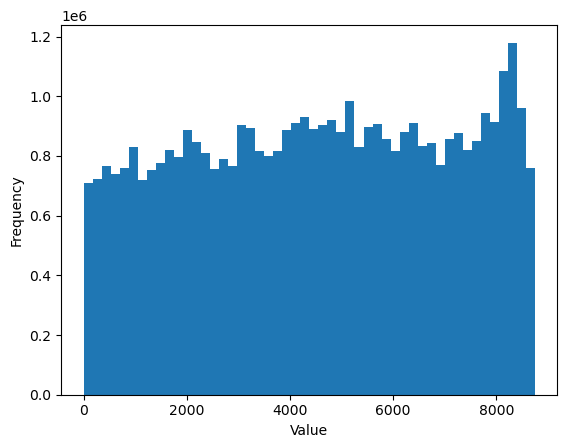

In [11]:
import matplotlib.pyplot as plt

# Check the distribution of the data
plt.hist(superpixel_labels.flatten(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Classification

In [12]:
pre_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/rectangle_45km_40km/pre_merged_alpha1_image_rectangle.npy")
post_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/post_merged_alpha_image_test_aligned_rectangle.npy")
slope = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Slope/slope_without_crop.npy")

In [13]:
# # Get common minimum shape across all relevant inputs
# min_rows = min(superpixel_labels.shape[0], log_ratio.shape[0], pre_alpha1.shape[0], post_alpha1.shape[0], slope.shape[0])
# min_cols = min(superpixel_labels.shape[1], log_ratio.shape[1], pre_alpha1.shape[1], post_alpha1.shape[1], slope.shape[1])
# print("min_rows", min_rows)
# # Crop all arrays to the same shape
# superpixel_labels_cropped = superpixel_labels[:min_rows, :min_cols]
# log_ratio_cropped = log_ratio[:min_rows, :min_cols]
# pre_alpha1_cropped = pre_alpha1[:min_rows, :min_cols]
# post_alpha1_cropped = post_alpha1[:min_rows, :min_cols]
# slope_cropped = slope[:min_rows, :min_cols]
# print("superpixel_labels_cropped", superpixel_labels_cropped.shape)

# # Feature extraction
# np.seterr(divide='ignore', invalid='ignore')
# mean_log_ratio = get_superpixel_means_as_features(superpixel_labels_cropped, log_ratio_cropped)
# median_pre_alpha1 = get_superpixel_medians_as_features(superpixel_labels_cropped, pre_alpha1_cropped)
# median_post_alpha1 = get_superpixel_medians_as_features(superpixel_labels_cropped, post_alpha1_cropped)
# # diff_alpha1 = median_pre_alpha1 - median_post_alpha1
# # median_slope = get_superpixel_medians_as_features(superpixel_labels_cropped, slope_cropped)
# std_features = get_superpixel_stds_as_features(superpixel_labels_cropped, log_ratio_cropped)
# # mean_slope = get_superpixel_means_as_features(superpixel_labels_cropped, slope_cropped)


In [14]:
np.seterr(divide='ignore', invalid='ignore')
#Extracting features
mean_log_ratio = get_superpixel_means_as_features(superpixel_labels, log_ratio)
std_features = get_superpixel_stds_as_features(superpixel_labels, log_ratio)
# mean_slope = get_superpixel_means_as_features(superpixel_labels, slope)


In [15]:
unique_superpixel_labels = np.unique(superpixel_labels)

unique_superpixel_labels_reshape = unique_superpixel_labels.reshape(-1,1)


In [16]:
# I need to check how to make a dataframe using these columns
fire_data = np.hstack([unique_superpixel_labels_reshape,mean_log_ratio, std_features])

In [17]:
import pandas as pd
# Create pandas dataframe with column names
df = pd.DataFrame(fire_data, columns=['superpixel_label','mean_log_ratio','std_features'])
print(df)

      superpixel_label  mean_log_ratio  std_features
0                  0.0       -1.484781      0.336461
1                  1.0       -1.901690      0.619995
2                  2.0       -2.111822      0.478584
3                  3.0       -1.657727      0.506481
4                  4.0       -1.074401      0.719245
...                ...             ...           ...
8745            8745.0       -1.925436      0.914458
8746            8746.0        0.557449      0.270161
8747            8747.0       -1.681068      0.636871
8748            8748.0       -0.392334      0.456418
8749            8749.0       -2.288388      0.185995

[8750 rows x 3 columns]


In [18]:
# Calculate the number of non-null values in each row
non_null_counts = df.count(axis=1)

# Get the total number of columns
num_columns = df.shape[1]

# Determine complete rows
complete_rows = df[non_null_counts == num_columns]

# Count the number of complete rows
num_complete_rows = len(complete_rows)
print(num_complete_rows)

8750


In [19]:
# retain only complete rows
df_cleaned = df.dropna()
print(len(df_cleaned))
# pd.set_option('display.max_rows',None)
print(df_cleaned)

8750
      superpixel_label  mean_log_ratio  std_features
0                  0.0       -1.484781      0.336461
1                  1.0       -1.901690      0.619995
2                  2.0       -2.111822      0.478584
3                  3.0       -1.657727      0.506481
4                  4.0       -1.074401      0.719245
...                ...             ...           ...
8745            8745.0       -1.925436      0.914458
8746            8746.0        0.557449      0.270161
8747            8747.0       -1.681068      0.636871
8748            8748.0       -0.392334      0.456418
8749            8749.0       -2.288388      0.185995

[8750 rows x 3 columns]


In [20]:
df_cleaned_for_model = df_cleaned.drop('superpixel_label', axis=1) # we don't want to use the superpixel label as a feature
print(df_cleaned_for_model)

      mean_log_ratio  std_features
0          -1.484781      0.336461
1          -1.901690      0.619995
2          -2.111822      0.478584
3          -1.657727      0.506481
4          -1.074401      0.719245
...              ...           ...
8745       -1.925436      0.914458
8746        0.557449      0.270161
8747       -1.681068      0.636871
8748       -0.392334      0.456418
8749       -2.288388      0.185995

[8750 rows x 2 columns]


In [21]:
from sklearn.cluster import KMeans
# Selecting the K-Means model with n_clusters=2
model = KMeans(n_clusters=2, n_init=10,random_state=1)

In [22]:
labeled_data = get_superpixel_model_labels(df_cleaned_for_model, model)
labeled_data = labeled_data.reshape(-1, 1)  # Ensure 2D shape
classes = get_array_from_features(superpixel_labels, labeled_data)
gdf = convert_labels_to_gdf(classes, profile)


Number of unique labels: 8750
Features shape: (8750, 1)


In [23]:
classes_unique = np.unique(classes)
classes_unique

array([0, 1], dtype=int32)

In [24]:
min_area_sq_km = 0.1
top_k_index = 20

In [25]:
gdf = filter_by_area(gdf, min_area_sq_km)
fire_gdf = gdf[gdf['class'] == 0]
fire_gdf = fire_gdf.sort_values(by='area_sq_km', ascending=False)
fire_gdf = fire_gdf.reset_index(drop=True)
fire_gdf = fire_gdf[0:top_k_index]

In [26]:
fire_gdf

,geometry,class,area_sq_km
0,"POLYGON ((-117.87201 34.34255, -117.87201 34.3...",0.0,310.164511
1,"POLYGON ((-117.75717 34.43195, -117.75717 34.4...",0.0,21.859021
2,"POLYGON ((-118.0308 34.439, -118.0308 34.43895...",0.0,19.522285
3,"POLYGON ((-117.81923 34.439, -117.81923 34.438...",0.0,18.620381
4,"POLYGON ((-117.89062 34.439, -117.89062 34.435...",0.0,18.435018
5,"POLYGON ((-117.8219 34.34372, -117.8219 34.343...",0.0,10.043580
6,"POLYGON ((-117.77734 34.34444, -117.77734 34.3...",0.0,8.689200
7,"POLYGON ((-117.76584 34.34678, -117.76584 34.3...",0.0,7.094912
8,"POLYGON ((-117.95052 34.439, -117.95052 34.438...",0.0,6.222715
9,"POLYGON ((-117.78195 34.15115, -117.78195 34.1...",0.0,5.944398


In [27]:
def make_center_point(longitude, latitude):
    buffer_point = Point(longitude, latitude)
    buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_point])

    return buffer_gdf

In [40]:
# # Plot the GeoDataFrame on top of the log_ratio image
# fig, ax = plt.subplots(figsize=(8, 8))
# show(log_ratio, ax=ax, transform=transform, cmap='viridis', interpolation='none')
# fire_gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=0.4)
# for idx, polygon in fire_gdf.iterrows():
#     x, y = polygon.geometry.centroid.x, polygon.geometry.centroid.y
#     ax.text(x, y, str(idx), fontsize=12, color='white', ha='center', va='center')
    
# make_center_point(-117.9297578, 34.332527).plot(ax=ax, color='blue', markersize=25)  # Plot the buffer point in blue

# plt.title('Possible Fire Polygons Superpixel_1')
# plt.show()

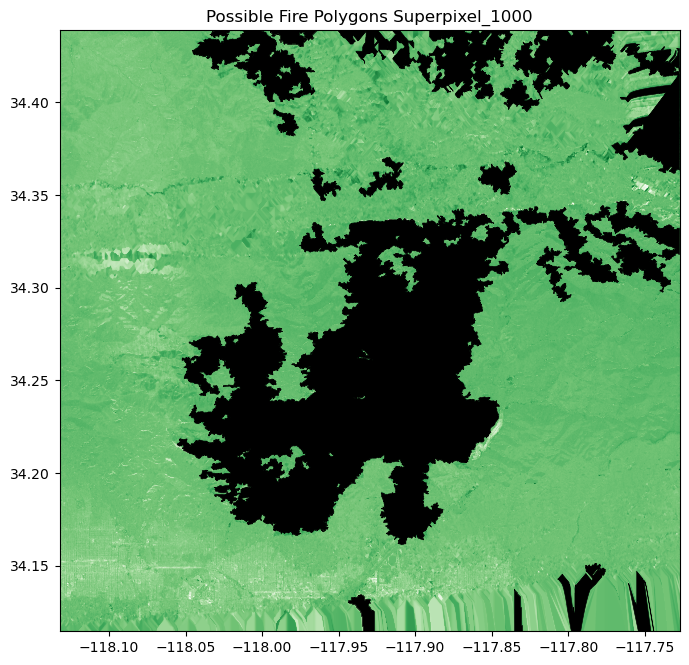

In [29]:
# Plot the GeoDataFrame on top of the log_ratio image
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the log_ratio image using 'Greens' colormap for background
show(log_ratio, ax=ax, transform=transform, cmap='Greens', interpolation='none')

# Plot fire polygons in solid black
fire_gdf.plot(ax=ax, facecolor="black", edgecolor="black", linewidth=0.4)

# Optional: annotate polygons
# for idx, polygon in fire_gdf.iterrows():
#     x, y = polygon.geometry.centroid.x, polygon.geometry.centroid.y
#     ax.text(x, y, str(idx), fontsize=12, color='white', ha='center', va='center')

# Plot center reference point in green (since background is green, using blue or red might improve visibility)
# make_center_point(-117.9297578, 34.332527).plot(ax=ax, color='blue', markersize=25)

plt.title('Possible Fire Polygons Superpixel_1000')
plt.show()



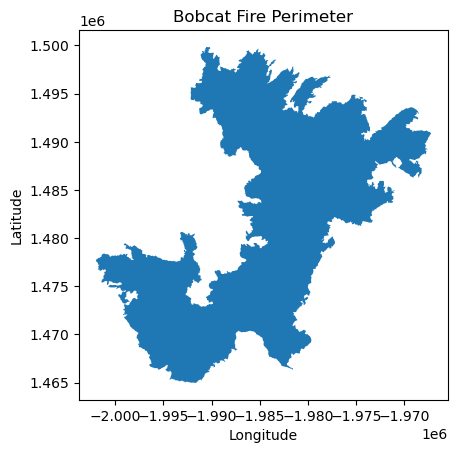

In [30]:
# Load the shapefile
perimeter = gpd.read_file("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca/ca3424811795920200906_20200703_20210706_burn_bndy.shp")

# Plot it
perimeter.plot()
plt.title("Bobcat Fire Perimeter")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.grid(True)
plt.show()


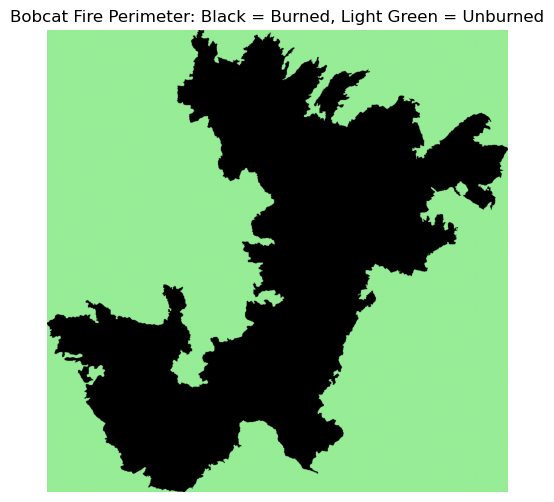

In [31]:
# Load shapefile
shapefile_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca/ca3424811795920200906_20200703_20210706_burn_bndy.shp"
perimeter = gpd.read_file(shapefile_path)

# Reproject to UTM if needed
if perimeter.crs.is_geographic:
    perimeter = perimeter.to_crs(epsg=32611)

# Raster resolution
resolution = 30

# Bounding box and raster size
minx, miny, maxx, maxy = perimeter.total_bounds
width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)

# Raster transform
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Rasterize: 1 inside, 0 outside
raster = rasterize(
    [(geom, 1) for geom in perimeter.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Define custom colormap: light green (0), black (1)
light_green = '#96ed96'  # soft/light green
black = '#000000'
cmap = ListedColormap([light_green, black])

# Display
plt.figure(figsize=(8, 6))
plt.imshow(raster, cmap=cmap, origin='upper')
plt.title("Bobcat Fire Perimeter: Black = Burned, Light Green = Unburned")
plt.axis('off')
plt.show()


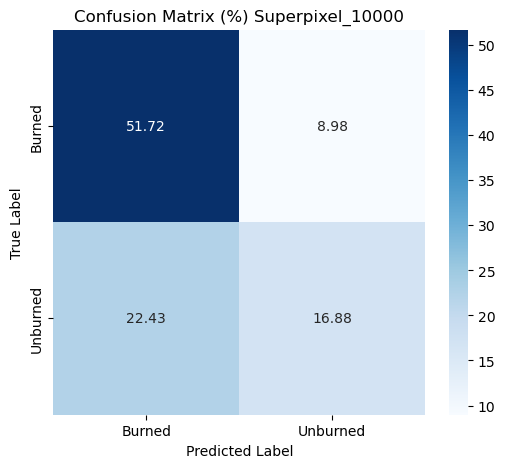


 Classification Metrics:
Accuracy : 0.6859
Precision: 0.6975
Recall   : 0.8520
F1-score : 0.7671


In [32]:


# === Load ground truth and prediction images ===
gt_img = Image.open('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/perimeter_generation_ground_truth.png').convert('L')
pred_img = Image.open('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/possible_fire_polygons_superpixel_10000.png').convert('L')

# === Resize prediction to match ground truth ===
pred_img_resized = pred_img.resize(gt_img.size, Image.NEAREST)

# Convert to numpy arrays
gt_array = np.array(gt_img)
pred_array = np.array(pred_img_resized)

# === Convert to binary masks (0 = unburned, 1 = burned) ===
gt_mask = (gt_array > 128).astype(np.uint8)
pred_mask = (pred_array > 128).astype(np.uint8)

# === Flatten for confusion matrix ===
y_true = gt_mask.flatten()
y_pred = pred_mask.flatten()

# === Compute confusion matrix (counts and percentages) ===
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
cm_percent = cm / cm.sum() * 100
labels = ['Burned', 'Unburned']



# === Compute accuracy and other metrics ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)



# === Plot heatmap (percentages) ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) Superpixel_10000')
plt.show()
print("\n Classification Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


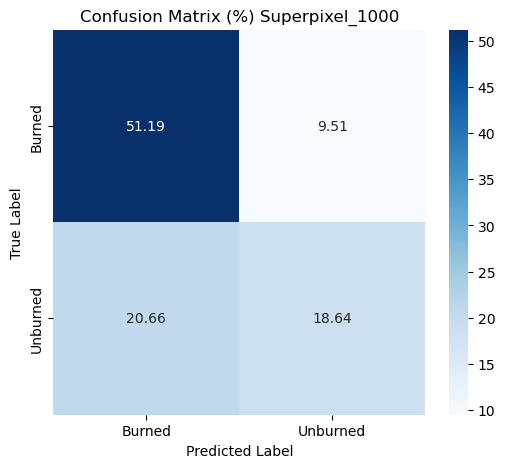


 Classification Metrics:
Accuracy : 0.6983
Precision: 0.7124
Recall   : 0.8434
F1-score : 0.7724


In [33]:

# === Load ground truth and prediction images ===
gt_img = Image.open('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/perimeter_generation_ground_truth.png').convert('L')
pred_img = Image.open('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/possible_fire_polygons_superpixel_1000.png').convert('L')

# === Resize prediction to match ground truth ===
pred_img_resized = pred_img.resize(gt_img.size, Image.NEAREST)

# Convert to numpy arrays
gt_array = np.array(gt_img)
pred_array = np.array(pred_img_resized)

# === Convert to binary masks (0 = unburned, 1 = burned) ===
gt_mask = (gt_array > 128).astype(np.uint8)
pred_mask = (pred_array > 128).astype(np.uint8)

# === Flatten for confusion matrix ===
y_true = gt_mask.flatten()
y_pred = pred_mask.flatten()

# === Compute confusion matrix (counts and percentages) ===
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
cm_percent = cm / cm.sum() * 100
labels = ['Burned', 'Unburned']



# === Compute accuracy and other metrics ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)



# === Plot heatmap (percentages) ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) Superpixel_1000')
plt.show()
print("\n Classification Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


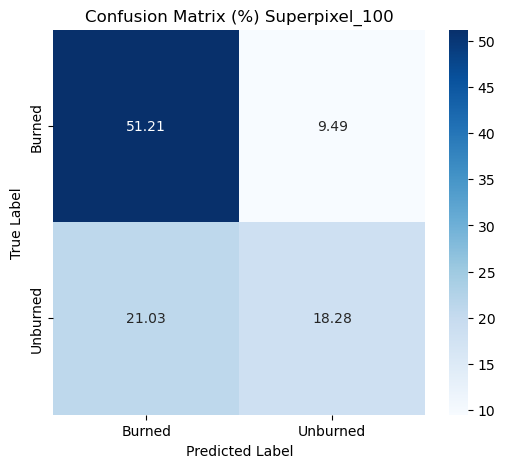


 Classification Metrics:
Accuracy : 0.6949
Precision: 0.7089
Recall   : 0.8437
F1-score : 0.7705


In [35]:


# === Load ground truth and prediction images ===
gt_img = Image.open('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/perimeter_generation_ground_truth.png').convert('L')
pred_img = Image.open('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/possible_fire_polygons_superpixel_100.png').convert('L')

# === Resize prediction to match ground truth ===
pred_img_resized = pred_img.resize(gt_img.size, Image.NEAREST)

# Convert to numpy arrays
gt_array = np.array(gt_img)
pred_array = np.array(pred_img_resized)

# === Convert to binary masks (0 = unburned, 1 = burned) ===
gt_mask = (gt_array > 128).astype(np.uint8)
pred_mask = (pred_array > 128).astype(np.uint8)

# === Flatten for confusion matrix ===
y_true = gt_mask.flatten()
y_pred = pred_mask.flatten()

# === Compute confusion matrix (counts and percentages) ===
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
cm_percent = cm / cm.sum() * 100
labels = ['Burned', 'Unburned']



# === Compute accuracy and other metrics ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)



# === Plot heatmap (percentages) ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) Superpixel_100')
plt.show()
print("\n Classification Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


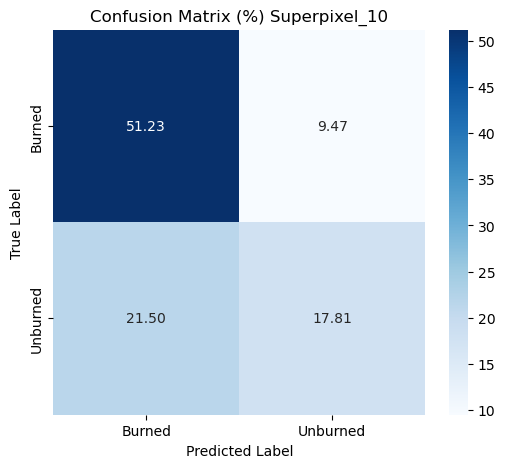


 Classification Metrics:
Accuracy : 0.6904
Precision: 0.7044
Recall   : 0.8440
F1-score : 0.7679


In [39]:


# === Load ground truth and prediction images ===
gt_img = Image.open('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/perimeter_generation_ground_truth.png').convert('L')
pred_img = Image.open('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/possible_fire_polygons_superpixel_10.png').convert('L')
# === Resize prediction to match ground truth ===
pred_img_resized = pred_img.resize(gt_img.size, Image.NEAREST)

# Convert to numpy arrays
gt_array = np.array(gt_img)
pred_array = np.array(pred_img_resized)

# === Convert to binary masks (0 = unburned, 1 = burned) ===
gt_mask = (gt_array > 128).astype(np.uint8)
pred_mask = (pred_array > 128).astype(np.uint8)

# === Flatten for confusion matrix ===
y_true = gt_mask.flatten()
y_pred = pred_mask.flatten()

# === Compute confusion matrix (counts and percentages) ===
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
cm_percent = cm / cm.sum() * 100
labels = ['Burned', 'Unburned']


# === Compute accuracy and other metrics ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)



# === Plot heatmap (percentages) ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) Superpixel_10')
plt.show()
print("\n Classification Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
